## Run wcs-based matching to compare object tables to metadetect no-shear catalogs

This takes as the metadetect no-shear catalog and object catalogs as inputs and runs matching using the wcs-based `WcsMatch` matcher.

#### Standard imports

In [6]:
import hpmcm
import tables_io
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

#### Set up the configuration

In [8]:
DATADIR = "test_data"   # Input data directory
shear_st = "0p01"       # Applied shear as a string
shear = 0.01            # Decimal version of applied shear
shear_type = "wmom"     # which object characterization to use 
tract = 10463           # which tract to study

REF_DIR = (37.9, 7.0)         # RA, DEC in deg of center of match region
REGION_SIZE = (0.375, 0.375)  # Size of match region in degrees
PIXEL_SIZE = 0.5/3600.        # Size of pixels used in matching
PIXEL_R2CUT = 4.              # Cut at distance**2 = 4 pixels
PIXEL_MATCH_SCALE = 1         # Use pixel scale to do matching

SOURCE_TABLEFILES = sorted(glob.glob(os.path.join(DATADIR, f"shear_*_{shear_st}_cleaned_{tract}_ns.pq")))
SOURCE_TABLEFILES.append(os.path.join(DATADIR, f"object_{tract}.pq"))
SOURCE_TABLEFILES.reverse()
SOURCE_TABLEFILES = [SOURCE_TABLEFILES[0], SOURCE_TABLEFILES[1]]
VISIT_IDS = np.arange(len(SOURCE_TABLEFILES))

#### Make the matcher, reduce the data

In [9]:
matcher = hpmcm.WcsMatch.create(REF_DIR, REGION_SIZE, pixelSize=PIXEL_SIZE, pixelR2Cut=PIXEL_R2CUT)
matcher.reduceData(SOURCE_TABLEFILES, VISIT_IDS)

/Users/echarles/software/DESC/HPMCM/src/hpmcm/wcs_match.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["xPix"] = xPix
/Users/echarles/software/DESC/HPMCM/src/hpmcm/wcs_match.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["yPix"] = yPix
/Users/echarles/software/DESC/HPMCM/src/hpmcm/wcs_match.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

#### Make a plot comparing the signal-to-noise in the two catalogs

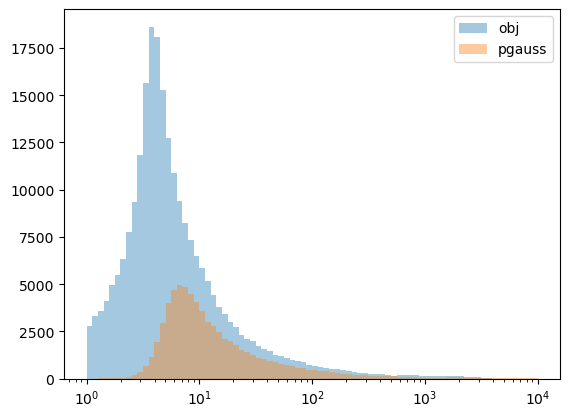

In [10]:
_ = plt.hist(matcher.fullData[0].SNR, bins=np.logspace(0, 4, 81), alpha=0.4, label="obj")
_ = plt.hist(matcher.fullData[1].SNR, bins=np.logspace(0, 4, 81), alpha=0.4, label="pgauss")
#_ = plt.hist(matcher.fullData[2].SNR, bins=np.logspace(0, 4, 81), alpha=0.4, label="pgauss")
#_ = plt.hist(matcher.fullData[3].SNR, bins=np.logspace(0, 4, 81), alpha=0.4, label="gauss")
_ = plt.xscale('log')
_ = plt.legend()

#### This should have made 3 x 3 cells

In [11]:
matcher.nCell

array([3., 3.])

#### Run the loop over cells

In [12]:
matcher.analysisLoop()

.. Done!


#### Show a single cluster

The x and y axes here are the in the cluster frame for a single cluster.
The color scale shows the number of sources per/pixel.

The `x` markers are the original source postions.   The `o` makters are the deshear positions.


In [18]:
cell = matcher.cellDict[matcher.getCellIdx(2,2)]
od = cell.analyze(None, 4)

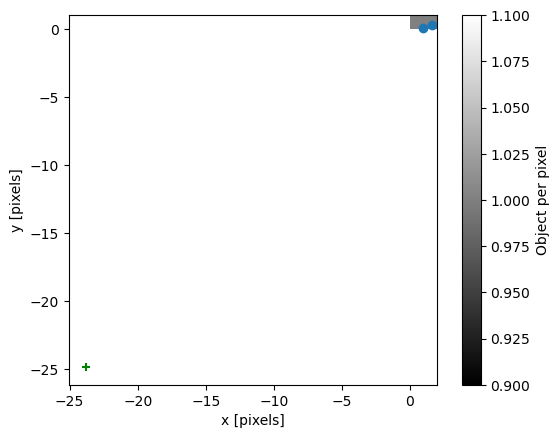

In [19]:
cluster = list(cell.clusterDict.values())[0]
_ = hpmcm.viz_utils.showCluster(od['image'], cluster, cell)

#### Classify the objects by match type

This looks at the characteristics of the matched objects and categorizes them.

In [20]:
objLists = hpmcm.classify.classifyObjects(matcher, snrCut=10)
hpmcm.classify.printObjectTypes(objLists)

All Objects:                                    19066
cut 1                                           0
cut 2                                           0
Used:                                           19066
good (n source from n catalogs):                4716
good faint                                      2187
faint (< n sources, SNR < cut):                 11454
mixed (n source from < n catalogs):             12
edge_mixed (mixed near edge of cell):           0
edge_missing (< n sources, near edge of cell):  0
edge_extra (> n sources, near edge of cell):    0
faint (< n sources, SNR < cut):                 11454
orphan (split off from larger cluster           2
one missing (n-1 sources, not near edge):       670
two missing (n-2 sources, not near edge):       0
many missing (< n-2 sources, not near edge):    0
extra (> n sources, not near edge):             25


In [21]:
n_good = len(objLists['ideal'])
bad_list = ['edge_mixed', 'edge_missing', 'edge_extra', 'orphan', 'missing', 'two_missing', 'many_missing', 'extra', 'caught']
n_bad = np.sum([len(objLists[x]) for x in bad_list])

In [22]:
effic = n_good/(n_good+n_bad)
effic_err = np.sqrt(effic*(1-effic)/(n_good+n_bad))
print(f"Effic: {effic:.5} +- {effic_err:.5f}")

Effic: 0.87124 +- 0.00455


#### Classify objcts using the object table as the reference

In [23]:
odict = hpmcm.classify.matchObjectsAgainstRef(matcher, snrCut=10.)
hpmcm.classify.printObjectMatchTypes(odict)

All             19066
Used            19066
  New             33
  New (faint)     46
In Ref          18987
Faint           11432
Good            4716
  Good (faint)    2187
Missing         639
Two Missing     0
All Missing     0
Extra           8
Caught          5


#### Display an object


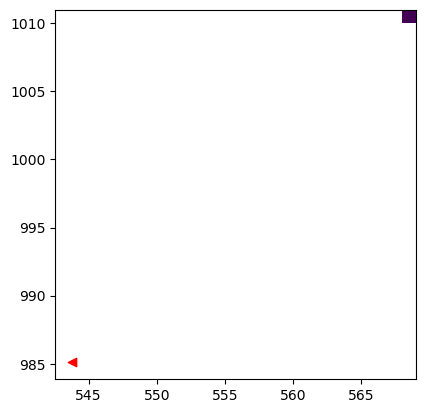

In [24]:
_ = hpmcm.viz_utils.showShearObj(matcher, objLists['missing'][0])